In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [4]:
# Parameters
DATA_DIR  = 'Aadhaar_otp/'
H, W, C = 50, 200, 3  # height, width, channels
D = 5  # Number of characters per image
characters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
N_LABELS = len(characters)  # 62 labels

In [5]:
# Mapping characters to numbers and vice versa
char_to_num = {char: idx for idx, char in enumerate(characters)}
num_to_char = {idx: char for char, idx in char_to_num.items()}

In [6]:
# Parse file path to extract label
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        return filename
    except Exception as e:
        print(f'Error parsing {filepath}: {e}')
        return None

In [7]:
# Load and prepare the data
files = glob.glob(os.path.join(DATA_DIR, "*.jpeg"))
attributes = list(map(parse_filepath, files))
df = pd.DataFrame(attributes, columns=['label'])
df['file'] = files
df = df.dropna()

In [8]:
# Split data into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [9]:
print(f'train count: {len(train_df)}, valid count: {len(valid_df)}, test count: {len(test_df)}')


train count: 7268, valid count: 808, test count: 898


In [10]:
# Data generator with augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [11]:
def get_data_generator(df, batch_size=16, shuffle=True):
    while True:
        if shuffle:
            df = df.sample(frac=1).reset_index(drop=True)
        images, labels = [], []
        for idx, row in df.iterrows():
            file, label = row['file'], row['label']
            im = Image.open(file).resize((W, H))
            im = np.array(im) / 255.0
            images.append(im)
            label_array = np.array([to_categorical(char_to_num[char], N_LABELS) for char in label])
            labels.append(label_array)
            if len(images) >= batch_size:
                yield np.array(images), np.array(labels)
                images, labels = [], []

In [12]:
# Model definition
input_layer = tf.keras.Input(shape=(H, W, C))
x = layers.Conv2D(32, 3, activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(D * N_LABELS, activation='softmax')(x)
x = layers.Reshape((D, N_LABELS))(x)


In [13]:
model = models.Model(inputs=input_layer, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 200, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 198, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 46, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 23, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 21, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 10, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,622,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 310)            │       317,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 62)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,328,630 (12.70 MB)

 Trainable params: 3,328,630 (12.70 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model
batch_size = 64
train_gen = get_data_generator(train_df, batch_size=batch_size)
valid_gen = get_data_generator(valid_df, batch_size=batch_size)

In [15]:
history = model.fit(train_gen,
                    steps_per_epoch=len(train_df)//batch_size,
                    epochs=5,
                    validation_data=valid_gen,
                    validation_steps=len(valid_df)//batch_size)

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.0634 - loss: 3.1897 - val_accuracy: 0.6195 - val_loss: 1.1884
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.6710 - loss: 0.9458 - val_accuracy: 0.9938 - val_loss: 0.0263
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.9737 - loss: 0.0824 - val_accuracy: 0.9977 - val_loss: 0.0085
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.9872 - loss: 0.0387 - val_accuracy: 0.9987 - val_loss: 0.0067
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9911 - loss: 0.0269 - val_accuracy: 0.9987 - val_loss: 0.0043


In [16]:
# Plot training history
def plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    axes[0].plot(history.history['accuracy'], label='Train accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

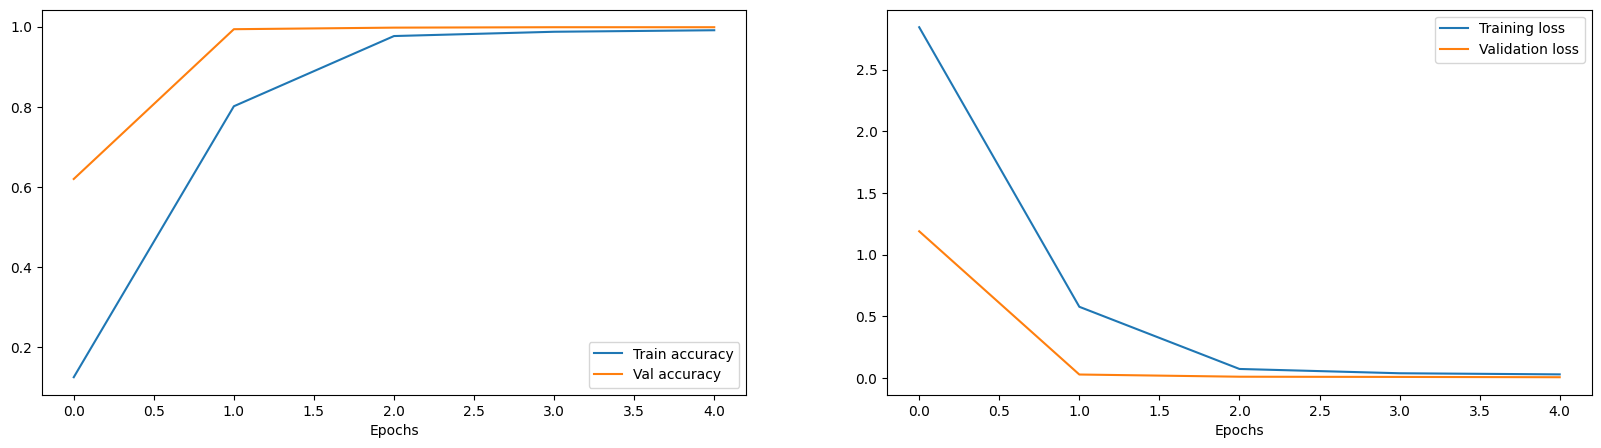

In [17]:
plot_train_history(history)
plt.show()

In [18]:
# Evaluate the model
test_gen = get_data_generator(test_df, batch_size=128, shuffle=False)
evaluation = model.evaluate(test_gen, steps=len(test_df)//128)
print(dict(zip(model.metrics_names, evaluation)))

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 1.0000 - loss: 8.0422e-04
{'loss': 0.0010007290402427316, 'compile_metrics': 1.0}


In [19]:
# Decode the predictions
def format_y(y):
    return ''.join(map(lambda x: num_to_char[int(x)], y))

In [20]:
# Display predictions
test_gen = get_data_generator(test_df, batch_size=128, shuffle=False)
x_test, y_test = next(test_gen)
y_pred = model.predict_on_batch(x_test)

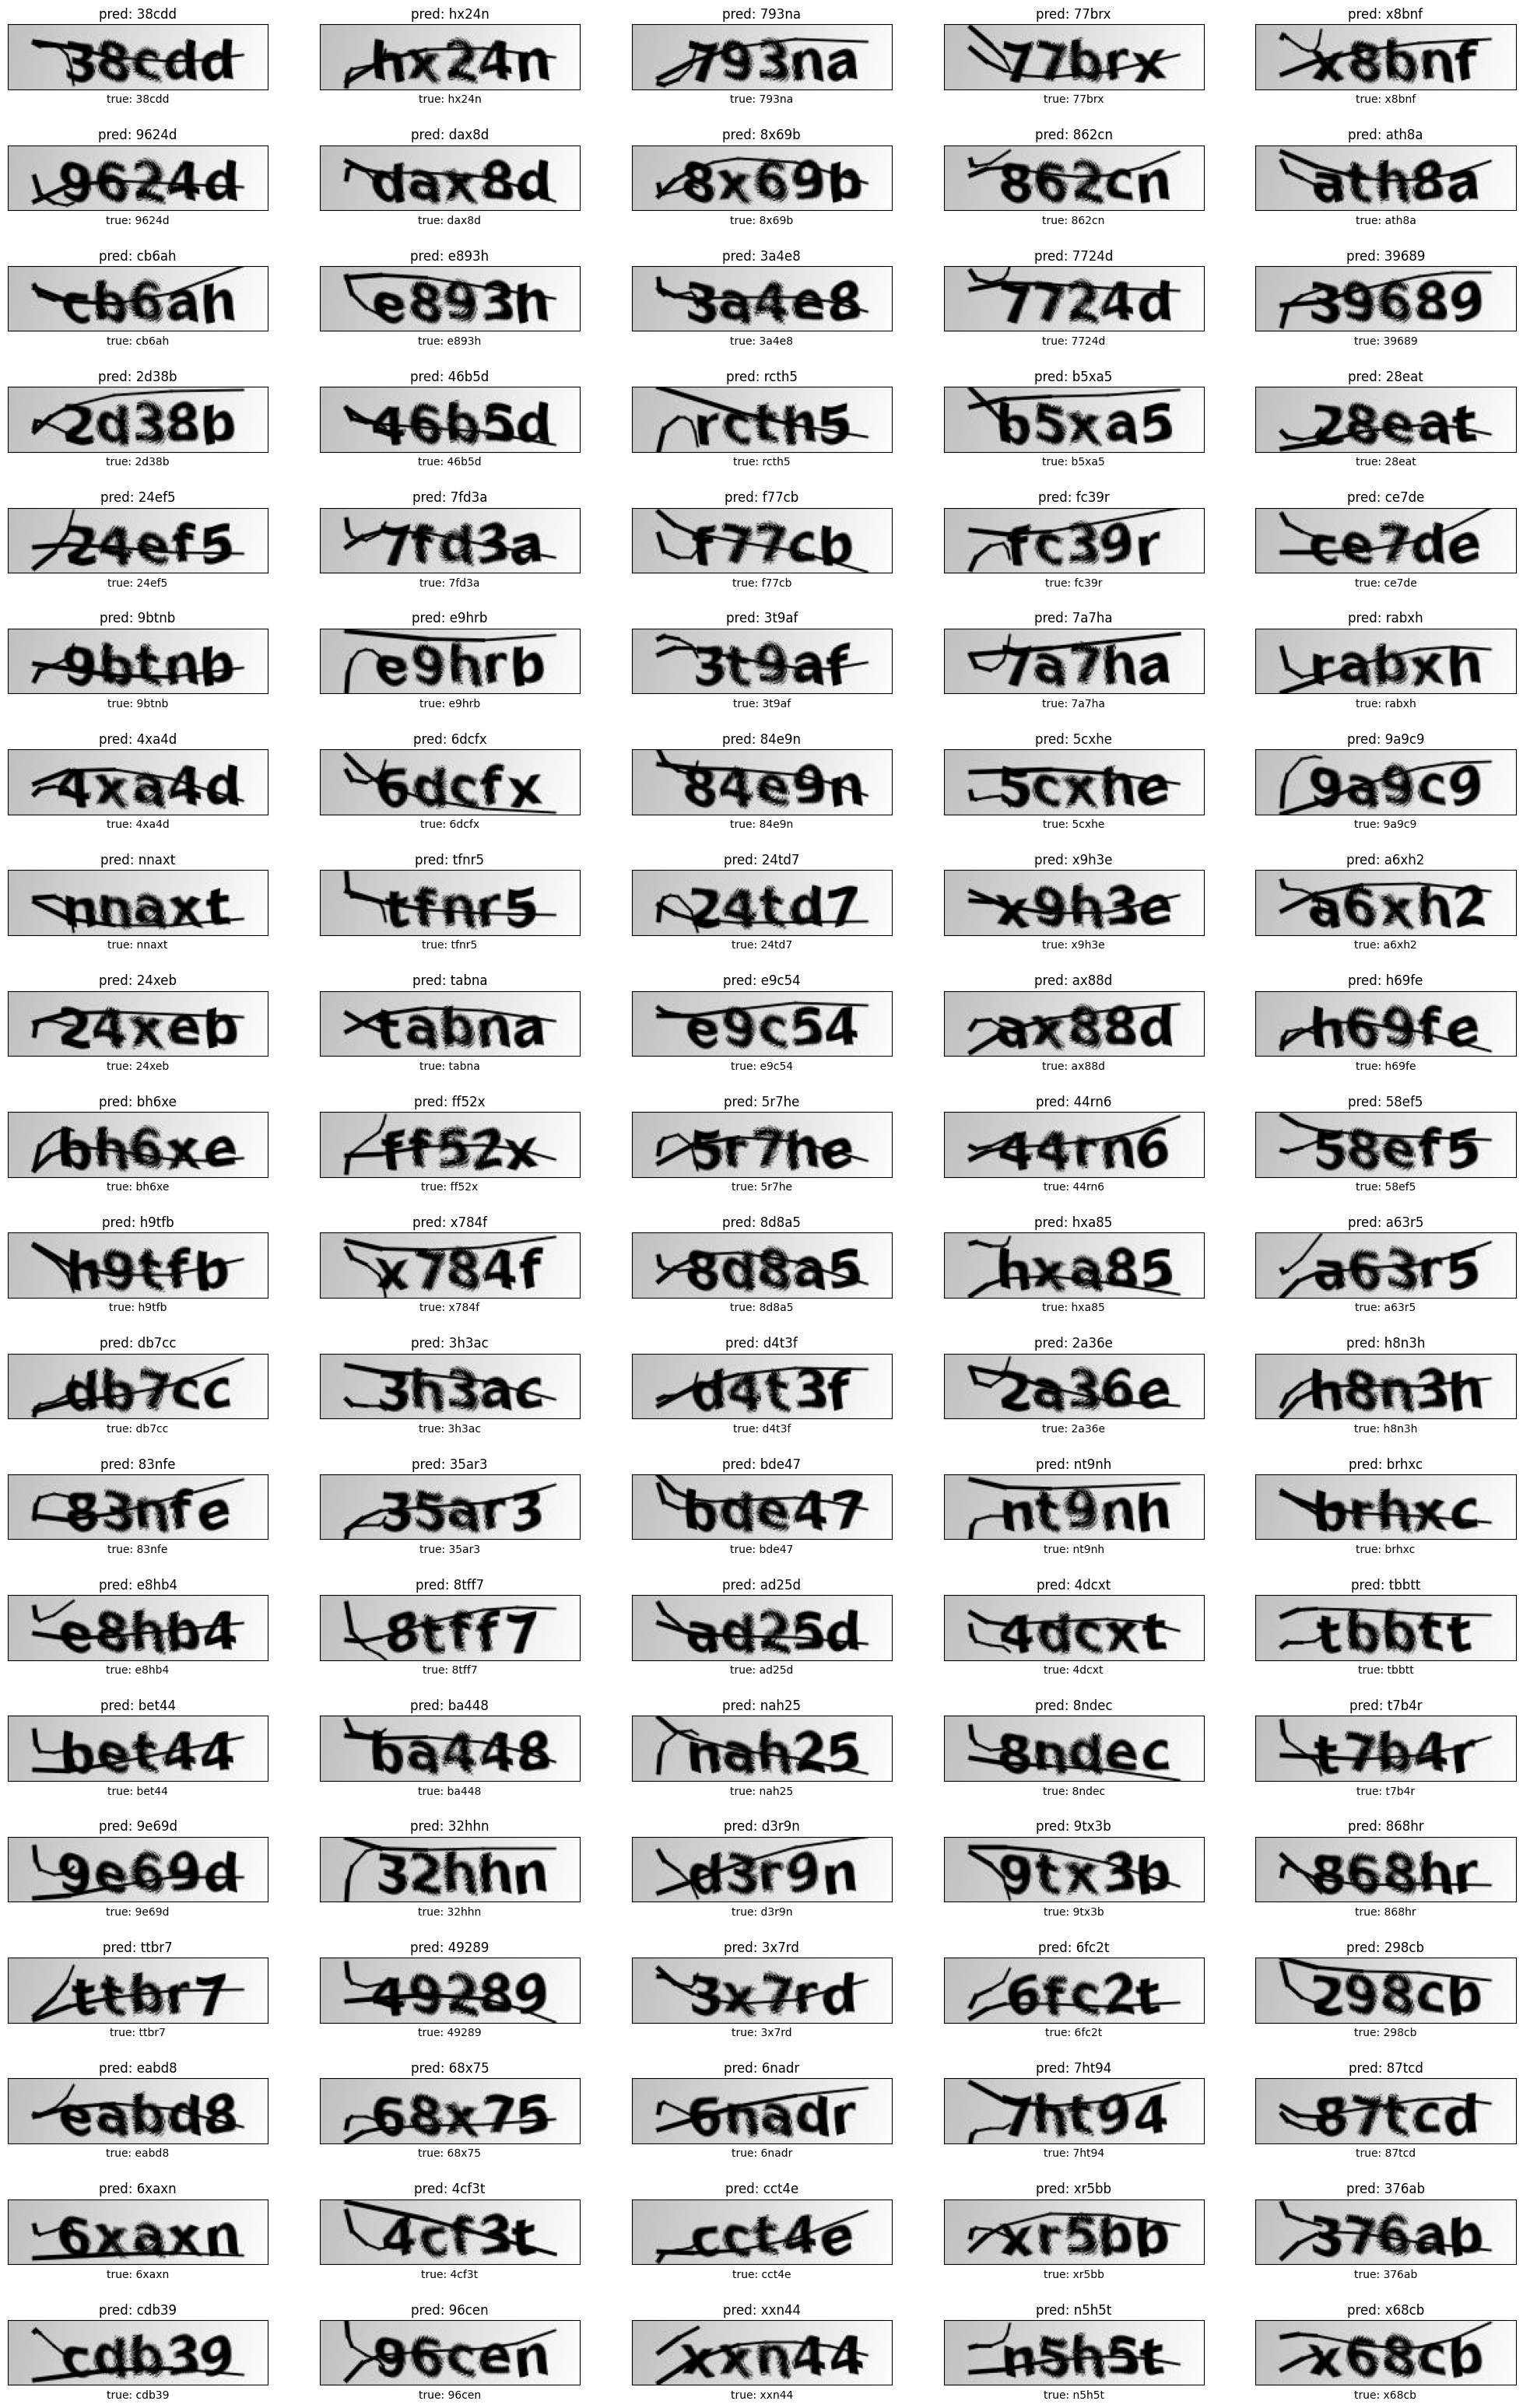

In [21]:
y_true = tf.math.argmax(y_test, axis=-1)
y_pred = tf.math.argmax(y_pred, axis=-1)
n = 100
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = np.ceil(n / n_cols).astype(int)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 40))
true_count = 0
false_count = 0
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title(f'pred: {format_y(y_pred[img_idx])}')
    ax.set_xlabel(f'true: {format_y(y_true[img_idx])}')
    ax.set_xticks([])
    ax.set_yticks([])
    if np.array_equal(y_pred[img_idx], y_true[img_idx]):
        true_count += 1
    else:
        false_count += 1
plt.show()

In [22]:
print(f"True predicted = {true_count}")
print(f"False predicted = {false_count}")

True predicted = 100
False predicted = 0


In [23]:
model.save('my_model.h5');